In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer 

from imblearn.combine import SMOTETomek, SMOTEENN

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv('telecom_data.csv')
df.shape

(7043, 21)

In [ ]:
idx_remove = df[df['TotalCharges'] == ' '].index.to_list()
df.drop(index=idx_remove, inplace=True)

In [7]:
idx_remove

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

In [3]:
idx_remove = [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]
df.drop(index=idx_remove, inplace=True)

In [4]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [5]:
df.drop(['customerID', 'gender', 'PhoneService'], axis=1, inplace=True)

### Type of Features

In [6]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print(f'Num of Numerical Features : {len(num_features)} {num_features}')

Num of Numerical Features : 4 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [7]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print(f'Num of Numerical Features : {len(cat_features)} {cat_features}')

Num of Numerical Features : 14 ['Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [8]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print(f'Num of Numerical Features : {len(discrete_features)} {discrete_features}')

Num of Numerical Features : 1 ['SeniorCitizen']


In [9]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print(f'Num of Numerical Features : {len(continuous_features)} {continuous_features}')

Num of Numerical Features : 3 ['tenure', 'MonthlyCharges', 'TotalCharges']


### Split X and Y

In [10]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [11]:
y.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: object

In [12]:
y = np.where(y == 'Yes', 1, 0)

In [13]:
y

array([0, 0, 1, ..., 0, 1, 0], shape=(7032,))

### Feature Encoding and Scaling

In [14]:
df.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [15]:
ord_columns = ['Contract']
ohe_columns = ['Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
               'PaperlessBilling', 'PaymentMethod']

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, ohe_columns),
        ("Ordinal_Encoder", ordinal_encoder, ord_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [16]:
X = preprocessor.fit_transform(X)

In [17]:
X

array([[ 0.        ,  1.        ,  1.        , ..., -1.28024804,
        -1.16169394, -0.99419409],
       [ 1.        ,  0.        ,  1.        , ...,  0.06430269,
        -0.26087792, -0.17373982],
       [ 1.        ,  0.        ,  1.        , ..., -1.23950408,
        -0.36392329, -0.95964911],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.87280842,
        -1.17000405, -0.85451414],
       [ 0.        ,  1.        ,  1.        , ..., -1.15801615,
         0.31916782, -0.87209546],
       [ 1.        ,  0.        ,  1.        , ...,  1.36810945,
         1.35793167,  2.01234407]], shape=(7032, 39))

## Classification

In [18]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

In [19]:
from sklearn.model_selection import  train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
X_train.shape, X_test.shape

((5161, 39), (1291, 39))

In [20]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [21]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "LightGBM Classifier": LGBMClassifier(),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [22]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    recall_list = []
    auc= []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        recall_list.append(model_test_recall)
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, recall_list)), columns=['Model Name', 'Recall']).sort_values(by=['Recall'], ascending=False)
        
    return report

In [24]:
base_model_report = evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9690
- F1 score: 0.9719
- Precision: 0.9760
- Recall: 0.9678
- Roc Auc Score: 0.9692


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9326
- F1 score: 0.9395
- Precision: 0.9337
- Recall: 0.9455
- Roc Auc Score: 0.9311


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9591
- F1 score: 0.9634
- Precision: 0.9586
- Recall: 0.9683
- Roc Auc Score: 0.9580
----------------------------------
Model performance for Test set
- Accuracy: 0.9582
- F1 score: 0.9622
- Precision: 0.9635
- Recall: 0.9608
- Roc Auc Score: 0.9579


Logistic Regression
Model performance for Training 

In [25]:
base_model_report

,Model Name,Recall
4,K-Neighbors Classifier,0.988811
5,XGBClassifier,0.973427
6,LightGBM Classifier,0.969231
0,Random Forest,0.967832
2,Gradient Boosting,0.960839
8,AdaBoost Classifier,0.958042
1,Decision Tree,0.945455
7,Support Vector Classifier,0.942657
3,Logistic Regression,0.937063


In [27]:
knn_params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
}

lightgbm_params = {
    'n_estimators': [50, 100, 150, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [-1, 3, 5, 7, 10],
    'num_leaves': [31, 50, 100, 150],
    'min_data_in_leaf': [20, 30, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_forest_params = {
    'n_estimators': [50, 100, 150, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
}

In [30]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ('K-Neighbors Classifier', KNeighborsClassifier(), knn_params),
    ("LightGBM Classifier", LGBMClassifier(verbose=-1), lightgbm_params),
    ("Random Forest", RandomForestClassifier(), random_forest_params)
]

In [31]:
model_param = {}

for name, model, params in randomcv_models:   
    try:
        random = RandomizedSearchCV(estimator=model,
                                     param_distributions=params,
                                     n_iter=100,
                                     cv=3,
                                     verbose=2, 
                                     n_jobs=-1)
        random.fit(X_res, y_res)
        model_param[name] = random.best_params_
    except Exception as e:
        print(f"Erro ao treinar o modelo {name}: {e}")
        model_param[name] = None  # Se ocorrer um erro, armazene None para esse modelo.

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
---------------- Best Params for K-Neighbors Classifier -------------------
{'weights': 'uniform', 'n_neighbors': 1, 'leaf_size': 40, 'algorithm': 'ball_tree'}
---------------- Best Params for LightGBM Classifier -------------------
{'subsample': 0.6, 'num_leaves': 100, 'n_estimators': 150, 'min_data_in_leaf': 20, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
---------------- Best Params for Random Forest -------------------
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'criterion': 'entropy'}


In [32]:
model_param

{'K-Neighbors Classifier': {'weights': 'uniform',
  'n_neighbors': 1,
  'leaf_size': 40,
  'algorithm': 'ball_tree'},
 'LightGBM Classifier': {'subsample': 0.6,
  'num_leaves': 100,
  'n_estimators': 150,
  'min_data_in_leaf': 20,
  'max_depth': -1,
  'learning_rate': 0.05,
  'colsample_bytree': 0.6},
 'Random Forest': {'n_estimators': 100,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'max_depth': 40,
  'criterion': 'entropy'}}

### Retraining the Model with best Parameters

In [33]:
best_models = {
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['K-Neighbors Classifier']),
    "LGBMClassifier": LGBMClassifier(**model_param['LightGBM Classifier'],n_jobs=-1),
    "Random Forest Classifier": RandomForestClassifier(**model_param['Random Forest']),
}

tuned_report =evaluate_models(X=X_res, y=y_res, models=best_models)

KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9845
- F1 score: 0.9861
- Precision: 0.9780
- Recall: 0.9944
- Roc Auc Score: 0.9833


LGBMClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9698
- F1 score: 0.9728
- Precision: 0.9708
- Recall: 0.9748
- Roc Auc Score: 0.9692


Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9706
- F1 score: 0.9735
- Precision: 0.9708
- Recall: 0.9762
- Roc Auc Score: 0.9699




In [34]:
tuned_report

,Model Name,Recall
0,KNeighborsClassifier,0.994406
2,Random Forest Classifier,0.976224
1,LGBMClassifier,0.974825


In [35]:
best_model = KNeighborsClassifier(**model_param['K-Neighbors Classifier'])
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9845
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       576
           1       0.98      0.99      0.99       715

    accuracy                           0.98      1291
   macro avg       0.99      0.98      0.98      1291
weighted avg       0.98      0.98      0.98      1291



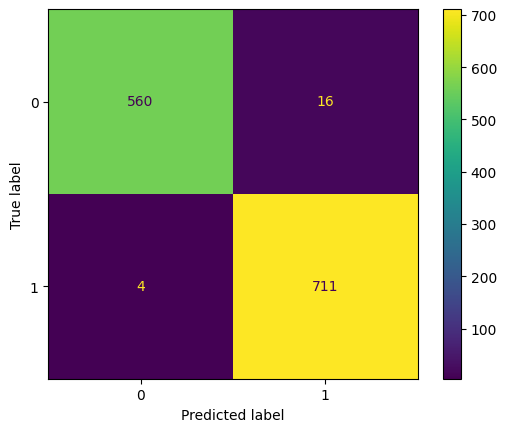

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test);